In [120]:
import numpy as np 
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

import geopandas as gpd
from shapely.geometry import Point

In [163]:
#Read data
train_vals = pd.read_csv('../data/training_vals.csv')
train_labels = pd.read_csv('../data/training_labels.csv')
test_vals = pd.read_csv('../data/test_vals.csv')

#To make my train_test split easier later on: 
train_vals.set_index('id', inplace=True)
train_labels.set_index('id', inplace=True)

#For convenience
train_vals = train_vals.merge(train_labels, left_index=True, right_index=True)



###  Nulls / Faulty data

In [122]:
#Null values found in columns labeled False
train_vals.notnull().all().sort_values().head(10)

scheme_management        False
public_meeting           False
scheme_name              False
installer                False
subvillage               False
permit                   False
funder                   False
extraction_type           True
extraction_type_group     True
waterpoint_type           True
dtype: bool

 #### Scheme Management

In [123]:
train_vals.scheme_management.value_counts(dropna=False)

VWC                 36793
WUG                  5206
NaN                  3877
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [124]:
#Scheme management involves who operates the well. Safe to change NaN to "unknown"
train_vals.scheme_management.fillna(value="Unknown", inplace=True)

In [125]:
len(train_vals.subvillage.notnull())

59400

#### Permit, Public Meeting

In [126]:
train_vals.permit.value_counts(dropna=False)

True     38852
False    17492
NaN       3056
Name: permit, dtype: int64

In [127]:
train_vals.public_meeting.value_counts(dropna=False)

True     51011
False     5055
NaN       3334
Name: public_meeting, dtype: int64

In [128]:
#Recode NaN to Unknown to end up with True/False/Unknown as only categories
train_vals.permit.fillna(value='Unknown', inplace=True)
train_vals.public_meeting.fillna(value='Unknown', inplace=True)

In [129]:
#Null values found in columns labeled False
train_vals.notnull().all().sort_values().head(10)

subvillage               False
installer                False
scheme_name              False
funder                   False
source_class              True
extraction_type           True
extraction_type_group     True
extraction_type_class     True
management                True
management_group          True
dtype: bool

#### Column Removal: First pass

Often, columns as specific as subvillage are accompanied by more general columns like region. I've chosen to use the more general columns to help the model best capture the trend in the data. 

Highly chaotic categorical features like installer and funder won't be used either, and the *name* of a scheme obviously has no predictive value. Note that scheme management was repaired for analysis a few cells earlier.

In [130]:
print("Number of unique subvillages: ", train_vals.subvillage.nunique())
print("Number of unique funders: ", train_vals.funder.nunique())
print("Number of unique installers: ", train_vals.installer.nunique())
print("Number of unique scheme names: ", train_vals.scheme_name.nunique())

Number of unique subvillages:  19287
Number of unique funders:  1897
Number of unique installers:  2145
Number of unique scheme names:  2696


In [131]:
#Get rid of a few columns: 
train_vals.drop(columns=['subvillage', 'installer', 'scheme_name', 'funder'], inplace=True)

In [132]:
#Sanity check: No more nulls? 
train_vals.notnull().all().all()

True

## EDA
Now that we have no more empty features, let's analyse the features themselves.

### Spatial Visualisation
Given the fact that we're trying to predict wether water wells are functional or not, it's a good idea to visually inspect the situation of the labeled wells before continuing. Perhaps location plays a role?

#### Cleaning / verifying coordinate columns

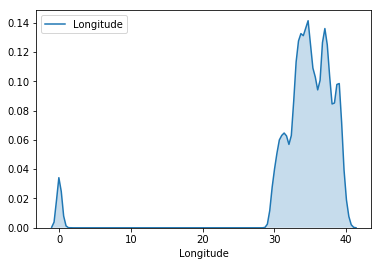

In [133]:
#Let's check if lat/lon are okay
#Longitude for Tanzania should be somewhere between 29 and 41
sns.kdeplot(data=train_vals['longitude'], legend=True, shade=True, label='Longitude')
plt.xlabel('Longitude')
None

In [134]:
#How many are wrong? 
#Using 25 is overly generous, but we shouldn't erroneously consider any locations to be faulty.
len(train_vals[train_vals.longitude < 25])

1812

In [135]:
#Obviously, we won't drop these rows from the entire dataset, but just for our current purposes
spatial_train_vals = train_vals[train_vals.longitude > 23]

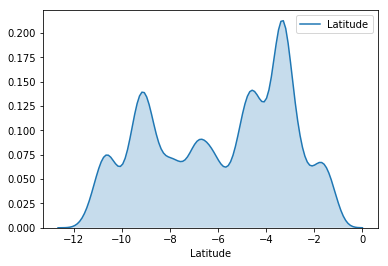

In [136]:
#Same deal for latitude
#Should be between -12 and 4 
sns.kdeplot(data=spatial_train_vals['latitude'], legend=True, shade=True, label='Latitude')
plt.xlabel('Latitude')
None

#### Setup

In [137]:
#Create geometry column and set up CRS
spatial_train_vals['Geometry'] = [Point(xy) for xy in zip(spatial_train_vals.longitude, spatial_train_vals.latitude)]

crs = {'init': 'epsg:4210'}

C:\Users\youri\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [138]:
#Instantiate GeoDataFrame & load map
geo_train = gpd.GeoDataFrame(spatial_train_vals, crs=crs, geometry='Geometry')

tanzania_map = gpd.read_file('../data/Tanzania_regions_2014/Tanzania_regions_2014.shp')

#### Plotting

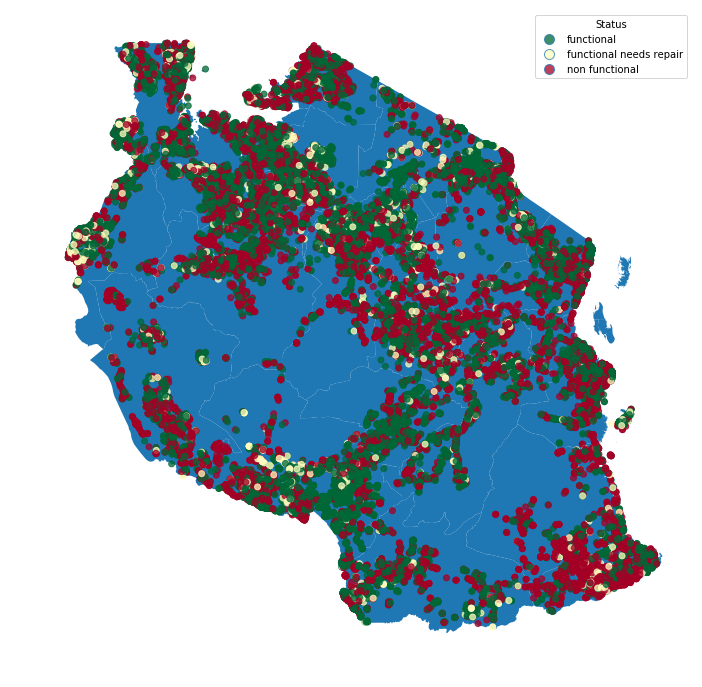

In [139]:
#Well, it certainly isn't a localized problem.
fig, ax = plt.subplots(figsize=(12,12), subplot_kw={'aspect': 'equal'})
tanzania_map.plot(ax=ax)
geo_train.plot(column='status_group', ax=ax, legend=True, cmap='RdYlGn_r', alpha=0.75, 
              legend_kwds={'title':'Status'})
ax.set_axis_off()
None

### Label categories
What do our target labels actually look like? 

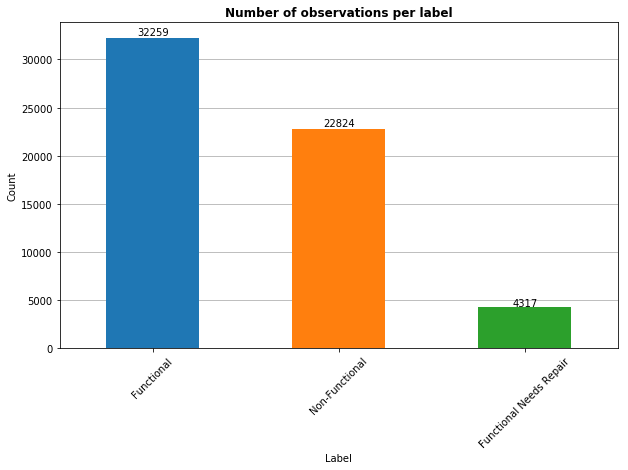

In [140]:
#Instantiate
fig, ax = plt.subplots(figsize=(10,6))
train_vals['status_group'].value_counts().plot.bar(ax=ax, rot=45)

#Prettify
ax.set_title('Number of observations per label', fontweight='bold')
ax.set_ylabel('Count')
ax.set_xlabel('Label')
ax.set_xticklabels(['Functional', 'Non-Functional', 'Functional Needs Repair'])
ax.yaxis.grid()
ax.set_axisbelow(True)

#Annotate
rects = ax.patches
for rect in rects:
    x=rect.get_x() + (rect.get_width()/2)
    y=rect.get_height() * 1.01
    ax.text(x, y, rect.get_height(), ha='center')

#### Water Amount: amount_tsh

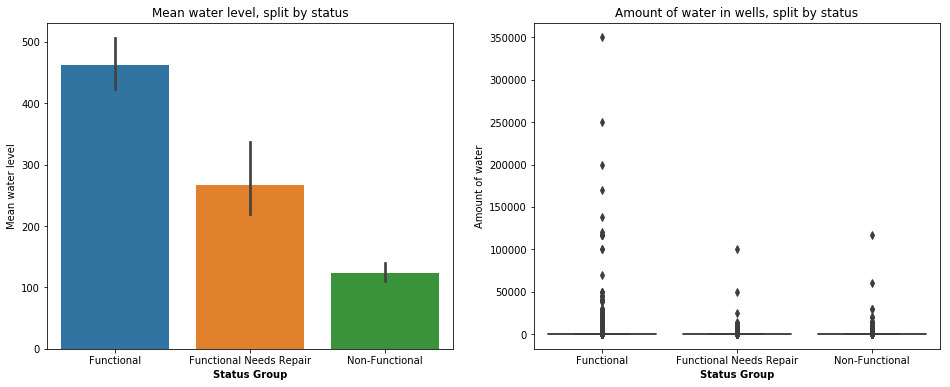

In [141]:
#Instantiate
fig, axes = plt.subplots(1, 2, figsize=(16,6))

#Barplot
sns.barplot(data=train_vals, y='amount_tsh', x='status_group', 
            order=['functional', 'functional needs repair', 'non functional'], ax=axes[0])
#Prettify
axes[0].set_title('Mean water level, split by status')
axes[0].set_ylabel('Mean water level')
axes[0].set_xlabel('Status Group', fontweight='bold')
axes[0].set_xticklabels(['Functional', 'Functional Needs Repair', 'Non-Functional'])

#Boxplot
sns.boxplot(data=train_vals, x='status_group', y='amount_tsh', order=['functional', 'functional needs repair', 'non functional'],
            ax=axes[1])
#Prettify
axes[1].set_title("Amount of water in wells, split by status")
axes[1].set_ylabel("Amount of water")
axes[1].set_xlabel("Status Group", fontweight='bold')
axes[1].set_xticklabels(['Functional', 'Functional Needs Repair', 'Non-Functional'])
None

While the barplot with grouped means looks great by itself, the boxplot (that isn't really a boxplot anymore) shows just how deceptive the means are, in this case. There's an overwhelming amount of zero-values in this feature. Let's investigate. 

In [142]:
#Note that the distribution looks really rather messed up
train_vals.groupby('status_group')['amount_tsh'].describe()

count        mean          std  min  25%  50%  \
status_group                                                               
functional               32259.0  461.798235  3889.735284  0.0  0.0  0.0   
functional needs repair   4317.0  267.071577  1925.026420  0.0  0.0  0.0   
non functional           22824.0  123.481230  1110.120571  0.0  0.0  0.0   

                          75%       max  
status_group                             
functional               50.0  350000.0  
functional needs repair  50.0  100000.0  
non functional            0.0  117000.0

In [143]:
#Empty or unregistered Wells
print("Amount of empty or unregistered wells: ", len(train_vals[train_vals['amount_tsh'] == 0]))
print("Amount of non-empty wells: ", len(train_vals[train_vals['amount_tsh'] != 0]))

Amount of empty or unregistered wells:  41639
Amount of non-empty wells:  17761


In [144]:
#It seems highly likely that 0 was used as value for unmeasured water levels, along with those wells that actually
#did have no water. That said, with such an overwhelming amount of zeroes, I am not going to use this column at all.

#While we're at it, also using this field to remove the date the observation was recorded, since that's obviously irrelevant.
train_vals.drop(columns=['amount_tsh', 'date_recorded'], inplace=True)

#### Elevation of well: gps_height

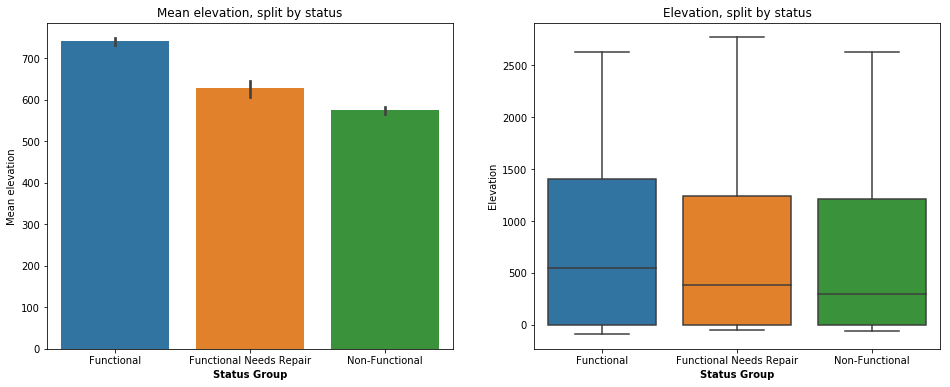

In [145]:
#Instantiate
fig, axes = plt.subplots(1, 2, figsize=(16,6))

#Barplot
sns.barplot(data=train_vals, y='gps_height', x='status_group', 
            order=['functional', 'functional needs repair', 'non functional'], ax=axes[0])
#Prettify
axes[0].set_title('Mean elevation, split by status')
axes[0].set_ylabel('Mean elevation')
axes[0].set_xlabel('Status Group', fontweight='bold')
axes[0].set_xticklabels(['Functional', 'Functional Needs Repair', 'Non-Functional'])

#Boxplot
sns.boxplot(data=train_vals, x='status_group', y='gps_height', order=['functional', 'functional needs repair', 'non functional'],
            ax=axes[1])
#Prettify
axes[1].set_title("Elevation, split by status")
axes[1].set_ylabel("Elevation")
axes[1].set_xlabel("Status Group", fontweight='bold')
axes[1].set_xticklabels(['Functional', 'Functional Needs Repair', 'Non-Functional'])
None

The means and distribution make this look like a feature that could well be used. Given the experience we've just had with amount_tsh, however, it's good to check if zero hasn't been treated as "null". Also, we should verify the elevations we see in the data.

In [146]:
#Instantiate
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'aspect': 'equal'})
tanzania_map.plot(ax=ax)
geo_train.plot(column='gps_height', ax=ax, cmap='RdYlGn_r', alpha=0.75)

#Prettify
ax.set_axis_off()
ax.set_title("Elevation of wells (m)", size=16)

#Manual colorbar, since GPD's built-in colorbar is far too big
from matplotlib.colors import Normalize
from matplotlib import cm
norm = Normalize(vmin=geo_train['gps_height'].min(), vmax=geo_train['gps_height'].max())
n_cmap = cm.ScalarMappable(norm=norm, cmap='RdYlGn_r')
n_cmap.set_array([])
ax.get_figure().colorbar(n_cmap, shrink=0.75)

#Store
plt.savefig('../img/water_well_elevation.png')

plt.close()
None

<img  align=left src='https://i.pinimg.com/originals/92/c5/ae/92c5ae442f4ace1a84e97046e6d8b685.jpg' width=450/>
<img align=right src='../img/water_well_elevation.png' width=450/>


Map courtesy of [Maps of World](https://www.mapsofworld.com). 

This is a tricky one. It seems there are specific regions where the elevation of wells was not measured properly. The vast majority of the east of the country was logged properly - observed elevation matches the actual elevation very well. The yellow and red parts of the visualisation also match the actual map well; the mountain ranges and plateaus are easily recognizable. 

That said, we also can't miss the three to four enormous blocks of (near-) zero elevation where there should be an elevation of at least several hundred meters. 

In [147]:
#Well elevation
print("Amount of wells recorded with 0 elevation: ", len(train_vals[train_vals['gps_height'] == 0]))
print("Amount of wells with recorded elevation: ", len(train_vals[train_vals['gps_height'] != 0]))

Amount of wells recorded with 0 elevation:  20438
Amount of wells with recorded elevation:  38962


Sadly, about a third of the dataset records at 0, and, according to the map of Tanzania, that should clearly not be the case. Since we can't possibly reliably impute elevation for large parts of the country (certainly not without overwritting perfectly good data), I find myself forced to take gps_height out of consideration as feature. 

In [148]:
#Remove cols
#Also remove longitude/latitude, as that's already been wrapped in the Geopandas dataframe. 
#Further removal is just a name column and an empty one that obviously have no predictive value.
train_vals.drop(columns=['gps_height', 'longitude', 'latitude', 'wpt_name', 'num_private'], inplace=True)

### Region / location features

We have a large number of different features that all amount to the same thing: a location feature. While it seems likely that location has an effect on water well funtionality, we should check first. 

Note that Tanzania has 31 regions, but we do not expect all of them to appear in our data. Earlier spatial visualization (found above) indicated that, for example, the islands to the east of the country did not show water wells featured in the data.

We also have a more general feature, basins, with fewer categories. We'll dive into both, but will not go into the several even more specific features, as those have far too many categories to generalize from. 

#### Basin vs Region

In [149]:
#Basin
basin_pivot = train_vals.pivot_table(values='public_meeting', index='basin', columns='status_group', aggfunc='count')
basin_pivot['total'] = basin_pivot['functional'] + basin_pivot['functional needs repair'] + basin_pivot['non functional']
for col in basin_pivot.columns: 
    basin_pivot[col] = basin_pivot[col] / basin_pivot['total'] * 100
    
#Region
region_pivot = train_vals.pivot_table(values='public_meeting', index='region', columns='status_group', aggfunc='count')
region_pivot['total'] = region_pivot['functional'] + region_pivot['functional needs repair'] + region_pivot['non functional']
for col in region_pivot.columns: 
    region_pivot[col] = region_pivot[col] / region_pivot['total'] * 100

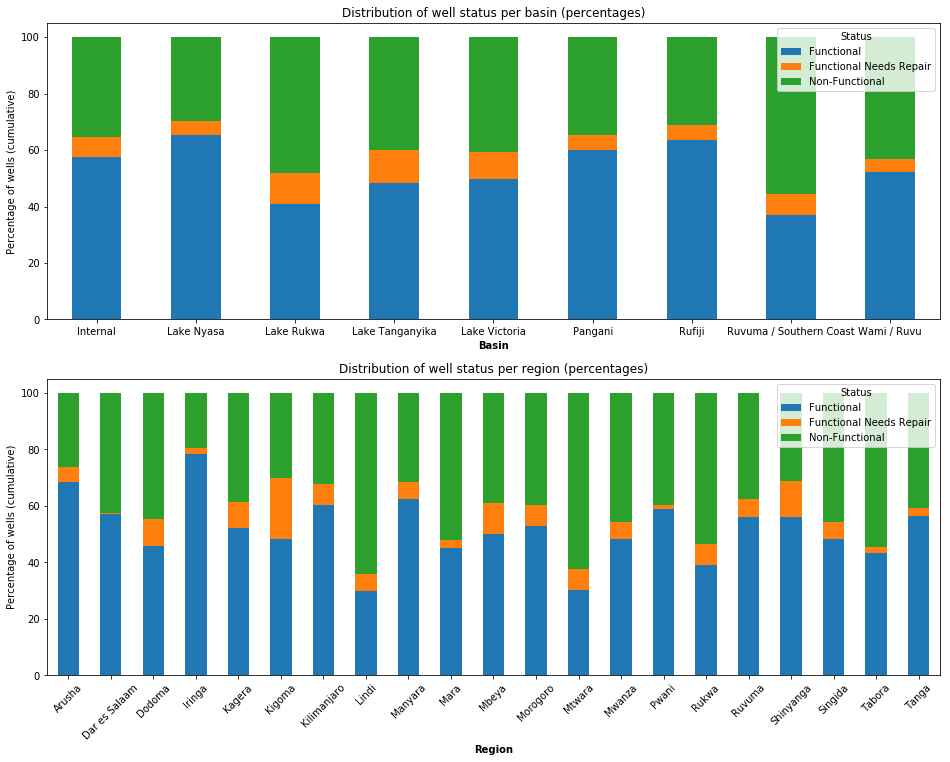

In [150]:
#Instantiate
fig, axes = plt.subplots(2, 1, figsize=(16,12))
basin_pivot.iloc[:, :3].plot.bar(stacked=True, ax=axes[0], rot=360)
region_pivot.iloc[:, :3].plot.bar(stacked=True, ax=axes[1], rot=45)

#Prettify Basin
axes[0].set_title('Distribution of well status per basin (percentages)')
axes[0].set_ylabel('Percentage of wells (cumulative)')
axes[0].set_xlabel('Basin', fontweight='bold')
axes[0].legend(title='Status', labels=['Functional', 'Functional Needs Repair', 'Non-Functional'])


#Prettify region
axes[1].set_title('Distribution of well status per region (percentages)')
axes[1].set_ylabel('Percentage of wells (cumulative)')
axes[1].set_xlabel('Region', fontweight='bold')
axes[1].legend(title='Status', labels=['Functional', 'Functional Needs Repair', 'Non-Functional'])
None

None

The differences between status (of wells) between regions is, as expected, an exaggerated version of the differences between basins. That said, the "functional needs repair" label varies little when looking at basins, while it knows large variations on a region-level. 

I'm fairly certain that using basins as feature instead of region would add little predictive ability to our model when it comes to that label, while I believe that region as feature would be of value to all three labels. I'll keep basins in mind as feature if the model does not perform well, but I'll go with just region as location feature for now. 

In [151]:
#Check for typos
train_vals.region.value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [152]:
#Note that region code doesn't match region, so we'll just encode region ourselves and get rid of this one.
train_vals.region_code.value_counts()

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

In [153]:
#Dropping all but our selected region column
train_vals.drop(columns=['basin', 'region_code', 'district_code', 'lga', 'ward'], inplace=True)

### Population
Note that this involves just the local population around the well itself.

In [154]:
#Continuous variable, so an ECDF might be helpful:
def ecdf(col): 
    x=np.sort(col)
    y=np.arange(1, len(x)+1) / len(x)
    return x,y
x_pop, y_pop = ecdf(train_vals.population)


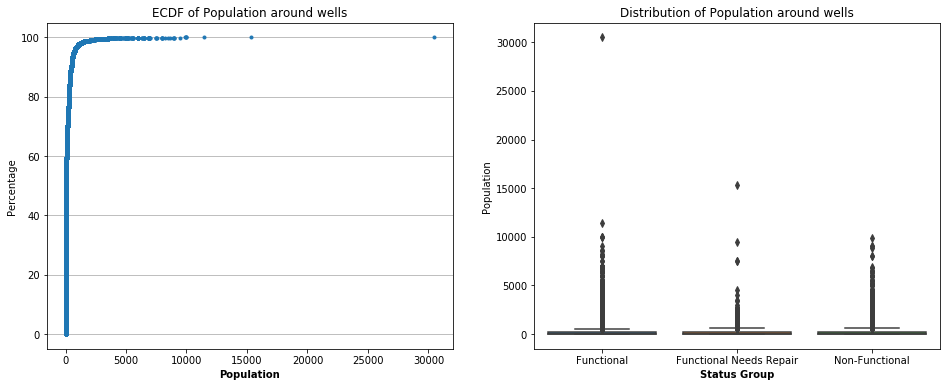

In [155]:
#Instantiate
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(x_pop, y_pop, marker='.', linestyle='none')
sns.boxplot(data=train_vals, x='status_group', y='population', order=['functional', 'functional needs repair', 'non functional'],
            ax=axes[1])
#Prettify
axes[0].set_xlabel('Population', fontweight='bold')
axes[0].set_yticklabels([0, 0, 20, 40, 60, 80, 100])
axes[0].set_ylabel('Percentage')
axes[0].set_title('ECDF of Population around wells')
axes[0].yaxis.grid()

axes[1].set_xlabel('Status Group', fontweight='bold')
axes[1].set_xticklabels(['Functional', 'Functional Needs Repair', 'Non-Functional'])
axes[1].set_ylabel('Population')
axes[1].set_title('Distribution of Population around wells')
None

In [156]:
#Quantitative version
train_vals.groupby('status_group').population.describe()

count        mean         std  min  25%   50%  \
status_group                                                               
functional               32259.0  187.553303  513.198991  0.0  0.0  40.0   
functional needs repair   4317.0  175.102154  433.033756  0.0  0.0  25.0   
non functional           22824.0  170.016430  413.094978  0.0  0.0   1.0   

                           75%      max  
status_group                             
functional               200.0  30500.0  
functional needs repair  245.0  15300.0  
non functional           230.0   9865.0

In [157]:
#Uninhabited wells or wells with unregistered population
print("Amount of uninhabited or unregistered wells: ", len(train_vals[train_vals['population'] == 0]))
print("Amount of inhabited or registered wells: ", len(train_vals[train_vals['population'] != 0]))

Amount of uninhabited or unregistered wells:  21381
Amount of inhabited or registered wells:  38019


The picture here is pretty much the same as that of *amount_tsh* or *gps_height*. Missing values have obviously been encoded as 0, which distorts the entire feature. 

We could theoretically impute values based on region, but that would add nothing, since we'd then just have another feature to describe location instead of another feature to describe water well function. 

Other forms of imputation are theoretically possible as well, but I'm wary of using such techniques on over a third of the entire dataset. This is a good option to keep in mind in case our model consistently underperforms, but for now, I find myself forced to take this feature out of consideration.

In [158]:
#Remove Population
train_vals.drop(columns=['population'], inplace=True)

### Construction year

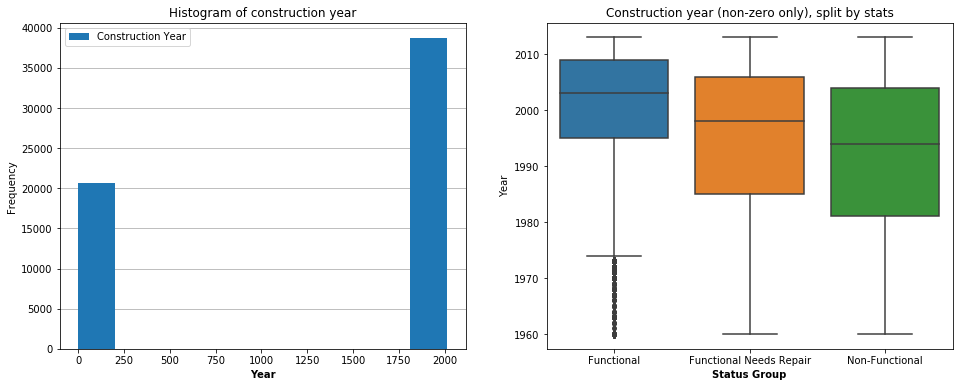

In [260]:
#Instantiate
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].hist(train_vals['construction_year'], label='Construction Year')
sns.boxplot(data=train_vals[train_vals['construction_year'] != 0], x='status_group', y='construction_year',
            order=['functional', 'functional needs repair', 'non functional'])
#Prettify
axes[0].legend()
axes[0].set_xlabel('Year', fontweight='bold')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of construction year')
axes[0].yaxis.grid()
axes[0].set_axisbelow(True)

#Prettify
axes[1].set_title("Construction year (non-zero only), split by stats")
axes[1].set_ylabel("Year")
axes[1].set_xlabel("Status Group", fontweight='bold')
axes[1].set_xticklabels(['Functional', 'Functional Needs Repair', 'Non-Functional'])

None

In [262]:
#Quantitative
train_vals[train_vals['construction_year'] != 0].groupby('status_group').construction_year.describe()

count         mean        std     min     25%  \
status_group                                                               
functional               21704.0  1999.938675  10.931700  1960.0  1995.0   
functional needs repair   2528.0  1995.257911  12.533262  1960.0  1985.0   
non functional           14459.0  1992.397538  13.222473  1960.0  1981.0   

                            50%     75%     max  
status_group                                     
functional               2003.0  2009.0  2013.0  
functional needs repair  1998.0  2006.0  2013.0  
non functional           1994.0  2004.0  2013.0

In [235]:
#Wells with unregistered construction year
print("Amount of unregistered wells: ", len(train_vals[train_vals['construction_year'] == 0]))
print("Amount of well-registered wells: ", len(train_vals[train_vals['construction_year'] != 0]))

Amount of unregistered wells:  20709
Amount of well-registered wells:  38691


The story here is, again, pretty much the same as with almost all other quantitative features we've seen. That said, on a theoretical level it would seem that the age of a water well is one of the, if not the most important feature determining the functionality of said well. Therefore, I *really* don't want to be forced to lose this feature. 

FILLINLATER: impute with non-zero means per status group per region

In [183]:
x = train_vals[train_vals.construction_year != 0]

In [190]:
train_vals.region.nunique()

21

In [188]:
x.region.nunique()

17

In [204]:
train_vals.groupby(['region', 'status_group']).construction_year.mean().round().astype(int)

region         status_group           
Arusha         functional                 1967
               functional needs repair    1984
               non functional             1968
Dar es Salaam  functional                 1958
               functional needs repair    2003
               non functional             1960
Dodoma         functional                    0
               functional needs repair       0
               non functional                0
Iringa         functional                 1871
               functional needs repair    1906
               non functional             1796
Kagera         functional                    0
               functional needs repair       0
               non functional                0
Kigoma         functional                 1991
               functional needs repair    1994
               non functional             1989
Kilimanjaro    functional                 1992
               functional needs repair    1973
               non fu

In [202]:
x.groupby(['region', 'status_group']).construction_year.mean().round().astype(int)

region         status_group           
Arusha         functional                 2000
               functional needs repair    1996
               non functional             1995
Dar es Salaam  functional                 2006
               functional needs repair    2003
               non functional             1995
Iringa         functional                 1999
               functional needs repair    1987
               non functional             1994
Kigoma         functional                 2000
               functional needs repair    1997
               non functional             1996
Kilimanjaro    functional                 2001
               functional needs repair    1992
               non functional             1989
Lindi          functional                 2002
               functional needs repair    1997
               non functional             1991
Manyara        functional                 2003
               functional needs repair    1999
               non fu

In [159]:
train_vals.head()

region public_meeting              recorded_by scheme_management  \
id                                                                         
69572   Iringa           True  GeoData Consultants Ltd               VWC   
8776      Mara        Unknown  GeoData Consultants Ltd             Other   
34310  Manyara           True  GeoData Consultants Ltd               VWC   
67743   Mtwara           True  GeoData Consultants Ltd               VWC   
19728   Kagera           True  GeoData Consultants Ltd           Unknown   

      permit  construction_year extraction_type extraction_type_group  \
id                                                                      
69572  False               1999         gravity               gravity   
8776    True               2010         gravity               gravity   
34310   True               2009         gravity               gravity   
67743   True               1986     submersible           submersible   
19728   True                  0         gravity               gravity   

      extraction_type_class management       ...       water_quality  \
id                                           ...                       
69572               gravity        vwc       ...                soft   
8776                gravity        wug       ...                soft   
34310               gravity        vwc       ...                soft   
67743           submersible        vwc       ...                soft   
19728               gravity      other       ...                soft   

      quality_group      quantity quantity_group                source  \
id                                                                       
69572          good        enough         enough                spring   
8776           good  insufficient   insufficient  rainwater harvesting   
34310          good        enough         enough                   dam   
67743          good           dry            dry           machine dbh   
19728          good      seasonal       seasonal  rainwater harvesting   

                source_type source_class              waterpoint_type  \
id                                                                      
69572                spring  groundwater           communal standpipe   
8776   rainwater harvesting      surface           communal standpipe   
34310                   dam      surface  communal standpipe multiple   
67743              borehole  groundwater  communal standpipe multiple   
19728  rainwater harvesting      surface           communal standpipe   

      waterpoint_type_group    status_group  
id                                           
69572    communal standpipe      functional  
8776     communal standpipe      functional  
34310    communal standpipe      functional  
67743    communal standpipe  non functional  
19728    communal standpipe      functional  

[5 rows x 23 columns]

### Some feature selection work

In [47]:
#Standard cols we always want to use
cols_always = ['amount_tsh', 'region_code', 'population', 
               'scheme_management', 'permit']

In [48]:
#First option: As general as possible
cols_general_classes = ['extraction_type_class', 'management_group', 'payment_type',
               'quality_group', 'quantity_group', 'source_class',
               'waterpoint_type_group']
cols_general = cols_always + cols_general_classes

In [49]:
#Second option: As specific as possible
cols_specific_classes = ['extraction_type', 'management', 'payment', 'water_quality', 
                'quantity', 'source', 'waterpoint_type']
cols_specific = cols_always + cols_specific_classes

In [50]:
cols_specific

['amount_tsh',
 'region_code',
 'population',
 'scheme_management',
 'permit',
 'extraction_type',
 'management',
 'payment',
 'water_quality',
 'quantity',
 'source',
 'waterpoint_type']

### sklearn setup

In [51]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.svm import SVC

In [52]:
le = LabelEncoder()

In [53]:
y = le.fit_transform(train_vals.status_group)

In [54]:
#Remember: 0=func, 1=repair, 2=broken
le.classes_

array(['functional', 'functional needs repair', 'non functional'],
      dtype=object)

In [55]:
x_general = train_vals[cols_general]
x_specific = train_vals[cols_specific]

In [56]:
for col in cols_general_classes:
    x_general[col] = le.fit_transform(x_general[col])
x_general["scheme_management"] = le.fit_transform(x_general["scheme_management"])

C:\Users\youri\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\youri\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [57]:
x_general['permit'] = np.where(x_general['permit'] == True, 1, 0)

C:\Users\youri\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [58]:
for col in cols_specific_classes:
    x_specific[col] = le.fit_transform(x_specific[col])
x_specific["scheme_management"] = le.fit_transform(x_specific["scheme_management"])

C:\Users\youri\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\youri\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [59]:
x_specific['permit'] = np.where(x_specific['permit'] == True, 1, 0)

C:\Users\youri\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [60]:
X_train_gen, X_test_gen, y_train_gen, y_test_gen = train_test_split(x_general, y, test_size=0.33, random_state=10)
X_train_spec, X_test_spec, y_train_spec, y_test_spec = train_test_split(x_specific, y, test_size=0.33, random_state=10)

#### SVC

In [61]:
#param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
#              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

IndentationError: unexpected indent (<ipython-input-61-d0abb7fb173d>, line 2)

In [ ]:
#svc_grid = GridSearchCV(SVC(), param_grid, cv=3, return_train_score=True)

In [ ]:
#svc_grid.fit(X_train_gen, y_train_gen)

In [62]:
svc_grid = SVC().fit(X_train_gen, y_train_gen)

KeyboardInterrupt: 

In [ ]:
#print(svc_grid.best_params_)
#print("Best score: %.4f" % svc_grid.best_score_)
print("Score on train set: %.4f" % svc_grid.score(X_train_gen, y_train_gen))
print("Score on test set: %.4f" % svc_grid.score(X_test_gen, y_test_gen))

In [ ]:
#TODO: Labelencode string cols & onehotencode them

#### Random Forest

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [91]:
param_grid = {'n_estimators': [40, 50, 100, 150, 200],
              'max_depth': [15, 20, 25]}

In [92]:
general_ranfor = GridSearchCV(RandomForestClassifier(class_weight='balanced'), param_grid, cv=3,
                             return_train_score=True).fit(X_train_gen, y_train_gen)

In [93]:
print(general_ranfor.best_params_)
#print(general_ranfor.feature_importances_
print("Score on train set: %.4f" % general_ranfor.score(X_train_gen, y_train_gen))
print("Score on test set: %.4f" % general_ranfor.score(X_test_gen, y_test_gen))

{'max_depth': 20, 'n_estimators': 150}
Score on train set: 0.8139
Score on test set: 0.7137


In [94]:
y_pred = general_ranfor.predict(X_test_gen)

In [95]:
print(classification_report(y_test_gen, y_pred))

             precision    recall  f1-score   support

          0       0.80      0.73      0.76     10749
          1       0.25      0.55      0.34      1385
          2       0.79      0.72      0.76      7468

avg / total       0.76      0.71      0.73     19602



In [ ]:
################################

In [69]:
spec_ranfor = RandomForestClassifier().fit(X_train_spec, y_train_spec)

In [70]:
print(spec_ranfor.feature_importances_)
print("Score on test set: %.4f" % spec_ranfor.score(X_test_spec, y_test_spec))

[0.05738909 0.09799113 0.19873135 0.0448835  0.02697222 0.08133688
 0.03892844 0.05569177 0.03972489 0.19345889 0.06081305 0.10407878]
Score on test set: 0.7649


In [71]:
y_pred = general_ranfor.predict(X_test_spec)

In [72]:
print(classification_report(y_test_spec, y_pred))

             precision    recall  f1-score   support

          0       0.68      0.59      0.63     10749
          1       0.12      0.01      0.01      1385
          2       0.51      0.69      0.58      7468

avg / total       0.57      0.59      0.57     19602

